# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../.."))

In [2]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from elements.abstracts import AbstractModulator
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from elements.simple import AdjustSize
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
import torch
import torchvision
import numpy
import timm
import pandas
from copy import deepcopy
from cluster import train, confusion, execute, epochs, SelectedGPUs
from PIL import Image
from itertools import product

In [3]:
FontLibrary.Fonts.PlotTitle.FontSize = 16

FontLibrary.Fonts.DescriptionLeft.FontSize = 12
FontLibrary.Fonts.DescriptionLeft.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionLeft.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionBottom.FontSize = 10
FontLibrary.Fonts.DescriptionBottom.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionBottom.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionTop.FontSize = 10
FontLibrary.Fonts.DescriptionTop.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionTop.FontStyle = 'italic'

FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FontLibrary.Fonts.AxisX.FontSize = 8
FontLibrary.Fonts.AxisY.FontSize = 8

FontLibrary.Fonts.GraphTitle.FontSize = 10

FigureWidthHeight = (6.69291, 10.1181-1.0)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA A100-SXM4-80GB


# Определение параметров модели

In [5]:
def resnet18(classes:int=10):
    return timm.create_model('resnet18', pretrained=False, in_chans=1, num_classes=classes).to(device)

In [6]:
def combined_loss(cross_entropy_to_mse_proportion:float=1.0):
    def loss_function(outputs, targets):
        CELoss = torch.nn.functional.cross_entropy(outputs, targets)
        MSELoss = torch.nn.functional.mse_loss(torch.nn.functional.softmax(outputs, dim=1), torch.nn.functional.one_hot(targets, num_classes=10).float())
        loss = cross_entropy_to_mse_proportion*CELoss + (1.0-cross_entropy_to_mse_proportion)*MSELoss
        return loss
    return loss_function

In [7]:
# Предпочтительные параметры
size = 9.765625E-6
near_N = 512 #2004 #1336
near_length = 5.0E-3
wavelength = 500.0E-9
detectors_amount = 24
masks_amount = 1
distance = 200.0E-3

# Параметры обучения
batch_size = 32
learning_rate = 0.009854
loss_function_proportion = 0.609798
optimizer_type_name = 'RMSprop'
optimizer_types_list = {'Adam':torch.optim.Adam, 'SGD':torch.optim.SGD, 'RMSprop':torch.optim.RMSprop, 'Adagrad':torch.optim.Adagrad}

# Параметры когерентности
spatial_coherence = 100.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 40

# Вычисляемые параметры
pixels = upper_integer(near_length/size)
length = pixels * size
cppp = int(near_N * size / length)
N = upper_integer(length*cppp / size) 
detector_size = length / 60

print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(length/pixels, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")

print(f"Временная когерентность:                  {engineering(time_coherence, 'с')}")
print(f"Время релаксации:                         {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность:           {engineering(spatial_coherence, 'м')}")
print(f"Количество усреднений:                    {mean_samples}")

print(f"Размер детекторов:                        {engineering(detector_size, 'м')}")
print(f"Количество детекторов:                    {detectors_amount} на {detectors_amount}")

print(f"Пропорция CE к MSE лосс:                  {loss_function_proportion}")
print(f"Размер батча:                             {batch_size}")
print(f"Тип оптимизатора:                         {optimizer_type_name}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       512
Количество пикселей маски:                512
Размер оптических элементов:              5.0 мм
Размер пикселя маски:                     9.766 мкм
Расстояние между слоями:                  200.0 мм
Временная когерентность:                  10.0 нс
Время релаксации:                         1.0 мкc
Пространственная когерентность:           100.0 мкм
Количество усреднений:                    40
Размер детекторов:                        83.333 мкм
Количество детекторов:                    24 на 24
Пропорция CE к MSE лосс:                  0.609798
Размер батча:                             32
Тип оптимизатора:                         RMSprop


# Диапазон расстояний

In [8]:
# # Настройка диапазона
# distance_left_multiplier = 0.1
# distance_right_multiplier = 1.0

# slices = 20
# distance_samples = 3
# distance_array = numpy.linspace(distance*distance_left_multiplier, distance*distance_right_multiplier, distance_samples)

In [9]:
# different_distance_propagations = []
# # Вычисления
# initial = torch.zeros((1, 1, N, N), device=device, dtype=torch.complex64)
# p0 = N//2 - upper_integer(N*size/(length*2))
# p1 = p0 + upper_integer(N*size/length)
# if p1 <= p0: p1 = p0+1 
# initial[0,0,p0:p1,p0:p1] = 1.0
# print(p0, p1)

# with torch.no_grad():
#     incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length)
#     incoherent_encoder, incoherent_decoder = incoherent.pair()
#     incoherent_encoder, incoherent_decoder = incoherent_encoder.to(device), incoherent_decoder.to(device)
#     for max_distance in tqdm(distance_array):
#         result = torch.zeros((slices, N), dtype=torch.float32)
#         for i, dist in enumerate(numpy.linspace(0, max_distance, slices)):
#             propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, dist).to(device)
#             result = incoherent_decoder.forward(propagation.forward(incoherent_encoder.forward(initial))).squeeze().abs().cpu()
#         different_distance_propagations.append((max_distance, result))

In [10]:
# plot = TiledPlot(14, 14)
# plot.FontLibrary = FontLibrary
# plot.title('Распостранение от единичной неоднородности')

# formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')

# axes = plot.axes.add((0,0),(1,1))
# axes.imshow(initial[0][0].abs().cpu(), aspect='auto', extent=[-length/2,+length/2]*2)
# axes.xaxis.set_major_formatter(formatter_xy)
# axes.yaxis.set_major_formatter(formatter_xy)
# plot.graph.label.x(unit_xy)
# plot.graph.label.y(unit_xy)

# plot.description.column.top('Исходное поле',0,1)

# for col, (dist, data) in enumerate(different_distance_propagations, 2):
#     formatter_z, unit_z = engineering.separatedformatter(dist, 'м')
#     plot.description.column.top(f"Расстояние: {engineering(dist,'м', 2)}", col)
    
#     axes = plot.axes.add(col, 0)
#     axes.imshow(torch.log10(data+0.001), aspect='auto', extent=[-length/2,+length/2,dist,0])
#     axes.xaxis.set_major_formatter(formatter_xy)
#     axes.yaxis.set_major_formatter(formatter_z)
#     plot.graph.label.x(unit_xy)
#     plot.graph.label.y(unit_z)

#     axes = plot.axes.add(col,1)
#     axes.grid(True)
#     axes.plot(numpy.linspace(-length/2,+length/2,N), data[-1])
#     plot.graph.description(scientific(torch.sum(data).item()))
#     axes.xaxis.set_major_formatter(formatter_xy)
#     plot.graph.label.x(unit_xy)

# plot.show()

# Инициализация моделей

In [15]:
# Модуль некогерентности
incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length)
incoherent_encoder, incoherent_decoder = incoherent.pair()
incoherent_encoder, incoherent_decoder = incoherent_encoder.to(device), incoherent_decoder.to(device)

# Модули детекторов
spectral_filter = Window(centers=wavelength, sizes=300.0E-9)
detectors_filter = Gaussian((detector_size, detector_size), (0,0))
detectors_incoherent = MatrixDetectors(N, length, wavelength, detectors_amount, detectors_filter, spectral_filter).to(device)
detectors_coherent = deepcopy(detectors_incoherent)

# Электронные модели
electronic_incoherent = resnet18()
electronic_coherent = deepcopy(electronic_incoherent)

# Оптические модели
adjuster = AdjustSize(N, N)
propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.4)
phase_modulators = [PhaseModulator(N, length, pixels) for i in range(masks_amount)]
amplitude_modulators = [AmplitudeModulator(N, length, pixels) for i in range(masks_amount)]
elements = [phase_modulators[0], amplitude_modulators[0]]
for phase_modulator, amplitude_modulator in zip(phase_modulators[1:], amplitude_modulators[1:]):
    elements.append(propagation)
    elements.append(phase_modulator)
    elements.append(amplitude_modulator)
elements.append(propagation)
optical_incoherent = CompositeModel(adjuster, incoherent_encoder, *deepcopy(elements), incoherent_decoder).to(device)
optical_coherent = CompositeModel(adjuster, *deepcopy(elements)).to(device)

# Гибридные модели
hybrid_model_incoherent = HybridModel(optical_incoherent, detectors_incoherent, electronic_incoherent).to(device)
hybrid_model_coherent = HybridModel(optical_coherent, detectors_coherent, electronic_coherent).to(device)

# Распределённые модели
model_incoherent = hybrid_model_incoherent
model_coherent = hybrid_model_coherent

# Набор данных
dataset = Dataset('MNIST', batch_size, None, None, torch.complex64, threads=1, preload=10)
dataset.padding(surface_ratio=0.4)
dataset.reference.same()
dataset.load.train()
dataset.load.test()

# Тип оптимизатора и лосс-функция
loss_function = combined_loss(loss_function_proportion)
optimizer_type = optimizer_types_list[optimizer_type_name]

# Визуализация набора данных

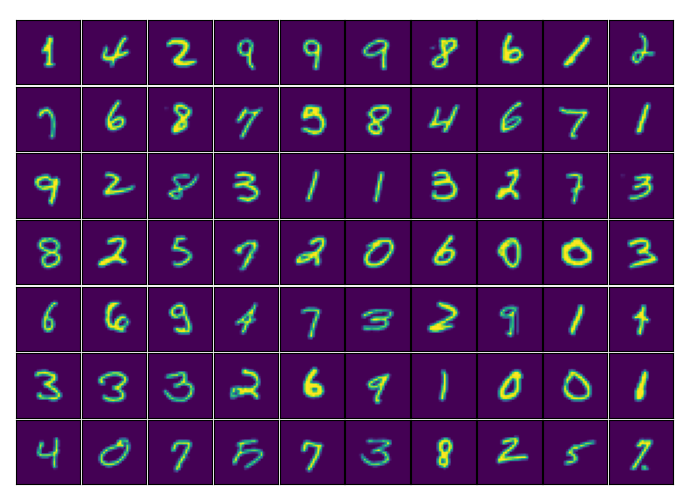

In [16]:
data_cols = 10
data_rows = 7
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary

for (image, _), (col,row) in zip(dataset.train, product(range(data_cols),range(data_rows))):
    axes = plot.axes.add(col,row)
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
    axes.imshow(image[0].squeeze().abs(), aspect='auto')

plot.show()

# Обучение модели

In [17]:
models_history, loss_histories, confusion_matrices_history = [], [], []

In [ ]:
SelectedGPUs.exclude(0)
mh, lh, cmh = epochs(20, 10, optical_incoherent, dataset, ImageComparisonMSE(), optimizer_type, lr=0.0003)
models_history += mh
loss_histories += lh
confusion_matrices_history += cmh

Training main thread PID is: 56479
Training thread#1 PID is: 56678
Training thread#6 PID is: 56683
Training thread#2 PID is: 56679
Training thread#3 PID is: 56680
Training thread#5 PID is: 56682
Training thread#4 PID is: 56681
Training thread#0 PID is: 56677
RLoss: 0.01920974226437977, RPI1000: -0.08848426428306001: 100%|█| 268/268 [02:4
Mean loss after epoch 1 is 0.02550828476339134
RLoss: 0.015864080657039665, RPI1000: -0.012903338241947601: 100%|█| 268/268 [02
Mean loss after epoch 2 is 0.01751781854806329
RLoss: 0.013226810120284503, RPI1000: -0.008296545344897927: 100%|█| 268/268 [02
Mean loss after epoch 3 is 0.014364386363121779
RLoss: 0.010877904321990775, RPI1000: -0.004257663942774711:  91%|▉| 243/268 [02

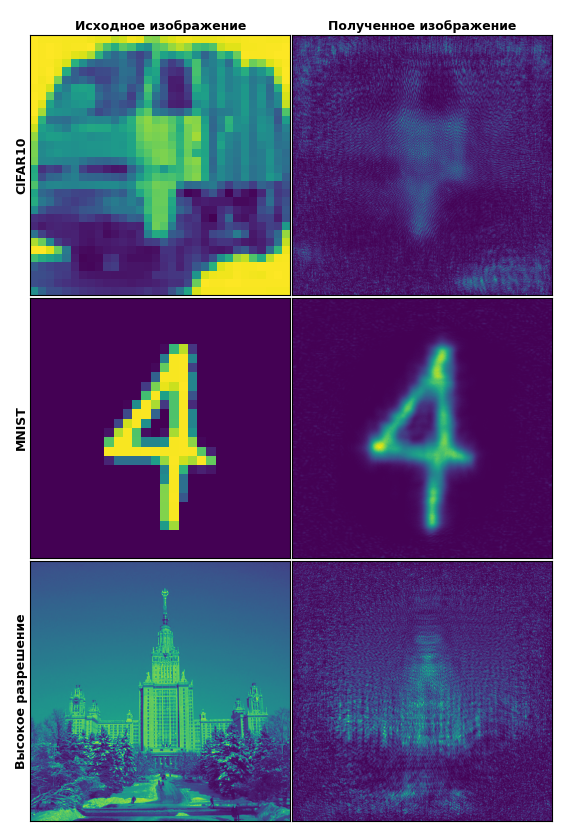

In [49]:
with torch.no_grad():
    images = []
    dataset = Dataset('CIFAR10', 1, None, None, torch.complex64, threads=1, preload=10)
    images.append(next(iter(dataset.test))[0])
    dataset = Dataset('MNIST', 1, None, None, torch.complex64, threads=1, preload=10)
    images.append(next(iter(dataset.test))[0])
    temp = interpolate(torch.mean(torchvision.transforms.functional.pil_to_tensor(Image.open('../../figures/MSU.jpg')).to(torch.float32), dim=0).unsqueeze(0).unsqueeze(0), (N,N))
    images.append(temp)
    labels = ['CIFAR10', 'MNIST', 'Высокое разрешение']
    
    plot = TiledPlot(*FigureWidthHeight)
    plot.FontLibrary = FontLibrary
    plot.description.column.top('Исходное изображение', 0)
    plot.description.column.top('Полученное изображение', 1)
    
    for row, (image, label) in enumerate(zip(images, labels)):
        plot.description.row.left(label, row)
        
        image = image.to(device)
        result = model.forward(image)
        image = adjuster.forward(image)
        image, result = image.clone().detach().squeeze().abs().cpu(), result.clone().detach().squeeze().abs().cpu()

        axes = plot.axes.add(0, row)
        axes.xaxis.set_visible(False)
        axes.yaxis.set_visible(False)
        axes.imshow(image, aspect='auto')

        axes = plot.axes.add(1,row)
        axes.xaxis.set_visible(False)
        axes.yaxis.set_visible(False)
        axes.imshow(result, aspect='auto')
    
    plot.show()